In [23]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import os
import xgboost as xgb
import shap
from sklearn.metrics import auc, roc_curve
from scripts.optuna_tuning import objective
import optuna

In [24]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 60*5]

In [25]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset/cases/'))

static = pd.read_parquet('data/datasets/base_dataset/meta.parquet')

data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)
    

train = data[data['split'] == 1]
test = data[data['split'] == 0]

In [26]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.metrics import auc, roc_curve
from scripts.optuna_tuning import objective
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

n_bootstraps = 200
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)


tpr_list, auc_list, thr_list  = [], [], []
tpr_train, auc_train  = [], []
sensitivity_list, specificity_list, ppv_list, npv_list = [], [], [], []
fpr = np.linspace(0, 1, 100)

FEATURE_NAME = [f'{signal}_ema_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + [f'{signal}_std_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + STATIC_FEATURE



# create a regressor
train = train.dropna(subset=FEATURE_NAME)
test = test.dropna(subset=FEATURE_NAME)
print(f'{len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}')

# try to open the model
try:
    model = xgb.XGBClassifier()
    model.load_model(f'data/models/xgb.json')
except:

    # creat an optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train, FEATURE_NAME), n_trials=100, show_progress_bar=True, )
    # get the best hyperparameters
    best_params = study.best_params
    # ret
    #refit the model with best parameters
    model = xgb.XGBClassifier(**best_params)
    model.fit(train[FEATURE_NAME], train.label, verbose=1)
    #save the model
    model.save_model(f'data/models/xgb.json')

# get training auc
y_pred = model.predict_proba(train[FEATURE_NAME])[:, 1]
y_train = train['label'].values
fpr_, tpr_, _ = roc_curve(y_train, y_pred)
auc_train = auc(fpr_, tpr_)

tpr_train = np.interp(np.linspace(0, 1, 100), fpr_, tpr_)

y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
y_test = test['label'].values

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    fpr_, tpr_, thr_ = roc_curve(y_test[indices], y_pred[indices])
    auc_ = auc(fpr_, tpr_)
    gmean = np.sqrt(tpr_ * (1-fpr_))
    id_thresh_opt = np.argmax(gmean)
    sensitivity_list.append(tpr_[id_thresh_opt]*100)
    specificity_list.append((1-fpr_[id_thresh_opt])*100)
    prevalence = np.mean(y_test[indices])
    ppv_list.append(100 * tpr_[id_thresh_opt]*prevalence / (tpr_[id_thresh_opt]*prevalence + fpr_[id_thresh_opt]*(1-prevalence)))
    npv_list.append(100 * (1-fpr_[id_thresh_opt])*(1-prevalence) / ((1-tpr_[id_thresh_opt])*prevalence + (1-fpr_[id_thresh_opt])*(1-prevalence)))


    tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
    thr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, thr_))
    auc_list.append(auc_)  


# compute mean ROC curve
tpr_mean = np.mean(tpr_list, axis=0)
tpr_std = np.std(tpr_list, axis=0)
thr_mean = np.mean(thr_list, axis=0)
sensi_mean = np.mean(sensitivity_list)
speci_mean = np.mean(specificity_list)
ppv_mean = np.mean(ppv_list)
npv_mean = np.mean(npv_list)
sensi_std = np.std(sensitivity_list)
speci_std = np.std(specificity_list)
ppv_std = np.std(ppv_list)
npv_std = np.std(npv_list)

# save the ROC curve
df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr_mean,
    'tpr_std':tpr_std,
    'threshold': thr_mean,
    'auc': np.round(np.mean(auc_list),2),
    'auc_std': np.round(pd.Series(auc_list).std(),2),
        'sensitivity': sensi_mean,
    'sensitivity_std': sensi_std,
    'specificity': speci_mean,
    'specificity_std': speci_std,
    'ppv': ppv_mean,
    'ppv_std': ppv_std,
    'npv': npv_mean,
    'npv_std': npv_std,
})
df.to_csv('data/results/xgboost_roc.csv', index=False)


91141 train samples and 38496 test samples, positive rate = 0.06


Best trial: 97. Best value: 0.815557: 100%|██████████| 100/100 [11:33<00:00,  6.94s/it]


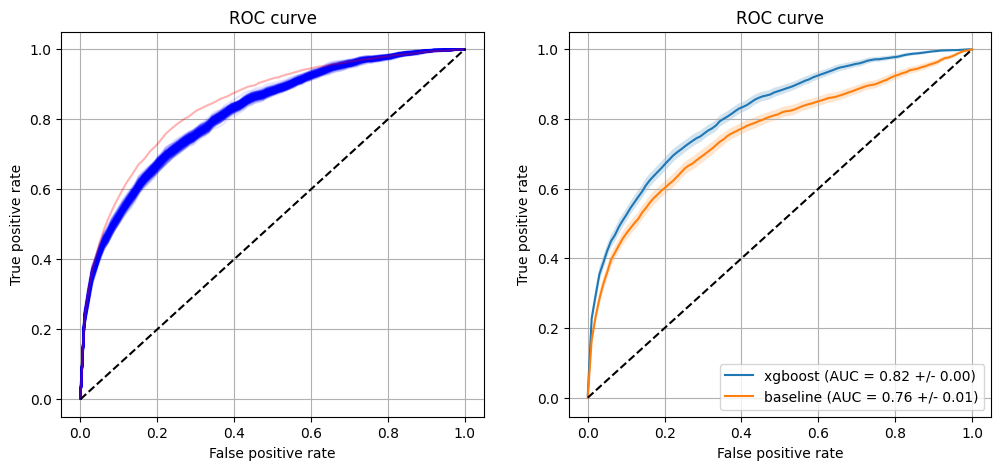

Z-score = 8.49
p-value = 0.00000000000000001040


In [27]:

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr_list)):
    plt.plot(fpr, tpr_list[i], 'b', alpha=0.1)
plt.plot(fpr, tpr_train, 'r', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
plt.fill_between(fpr, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr, tpr_mean, label=f'xgboost (AUC = {np.mean(auc_list):.2f} +/- {pd.Series(auc_list).std():.2f})')

#add baseline to the plot
df_baseline = pd.read_csv('data/results/baseline_roc.csv')
plt.fill_between(df_baseline.fpr, df_baseline.tpr - 2*df_baseline.tpr_std, df_baseline.tpr + 2*df_baseline.tpr_std, alpha=0.2)
plt.plot(df_baseline.fpr.values, df_baseline.tpr.values, label=f'baseline (AUC = {df_baseline.auc[0]:.2f} +/- {df_baseline.auc_std[0]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

Z_score = (np.mean(auc_list) - df_baseline.auc[0])/np.sqrt(df_baseline.auc_std[0]**2 + pd.Series(auc_list).std()**2)
print(f'Z-score = {Z_score:.2f}')
import scipy.stats
p_value = scipy.stats.norm.sf(abs(Z_score)) #one-sided
# p_value = 1 - 0.5*(1 + np.math.erf(Z_score/np.sqrt(2)))
print(f'p-value = {p_value:.20f}')


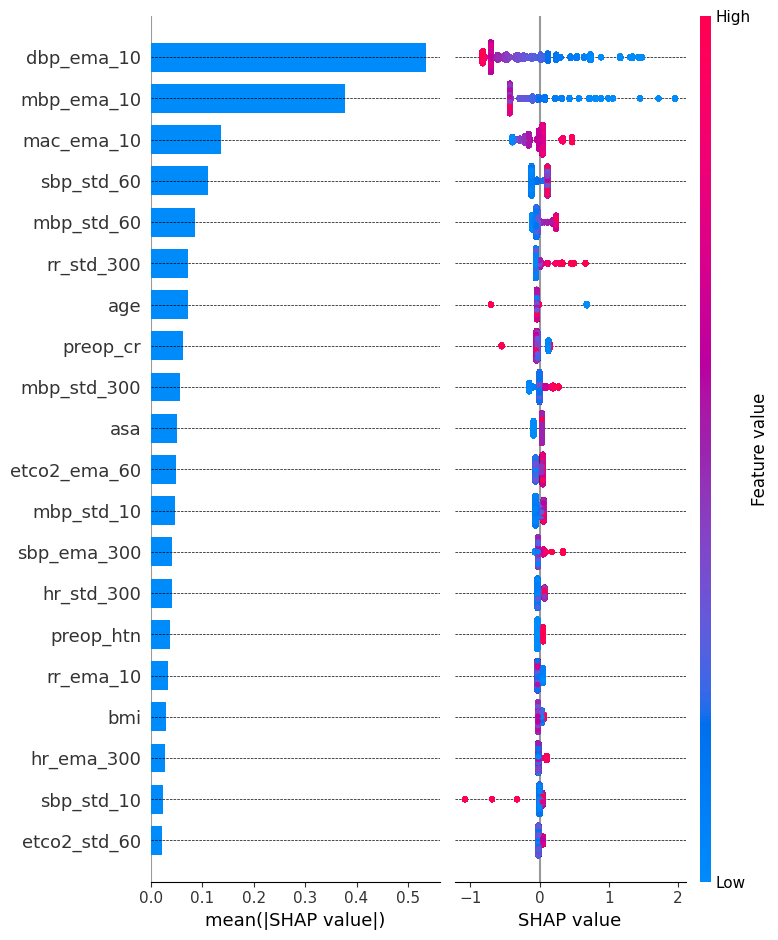

In [28]:
# use SHAP to explain the model
shap.initjs()
nb_max_feature = 20

model = xgb.Booster()
model.load_model(f'data/models/xgb.json')
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[FEATURE_NAME])
test_data = data[FEATURE_NAME]



# plot the SHAP value
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean(|SHAP value|)')
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, max_display=nb_max_feature)
#remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
#add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.savefig('./report/figures/shap_xgboost.pdf', bbox_inches='tight', dpi=600)
plt.show()

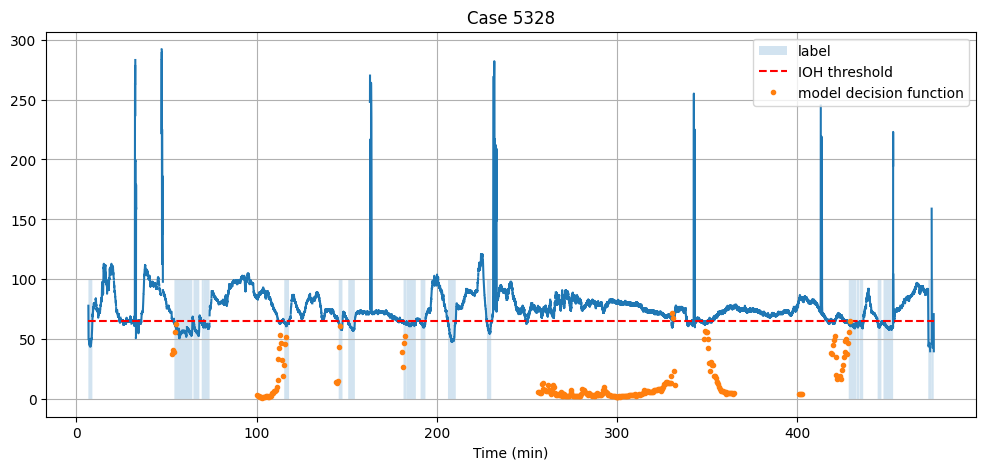

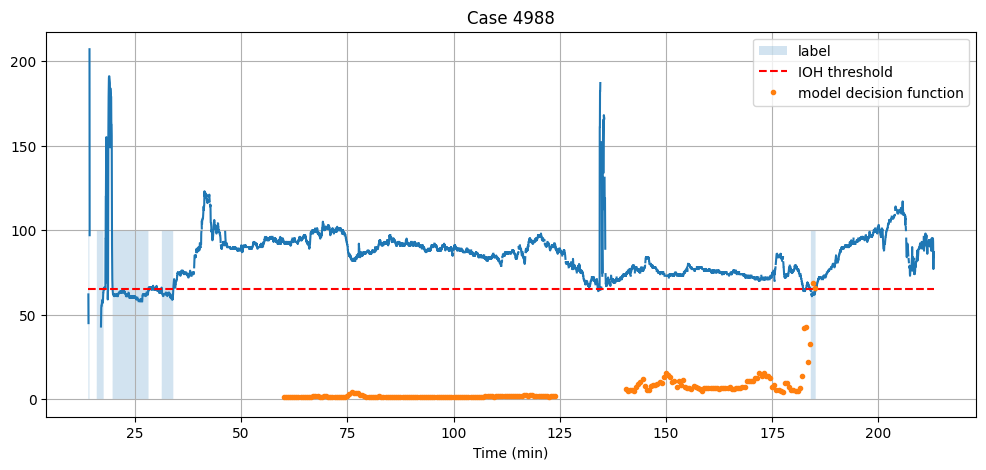

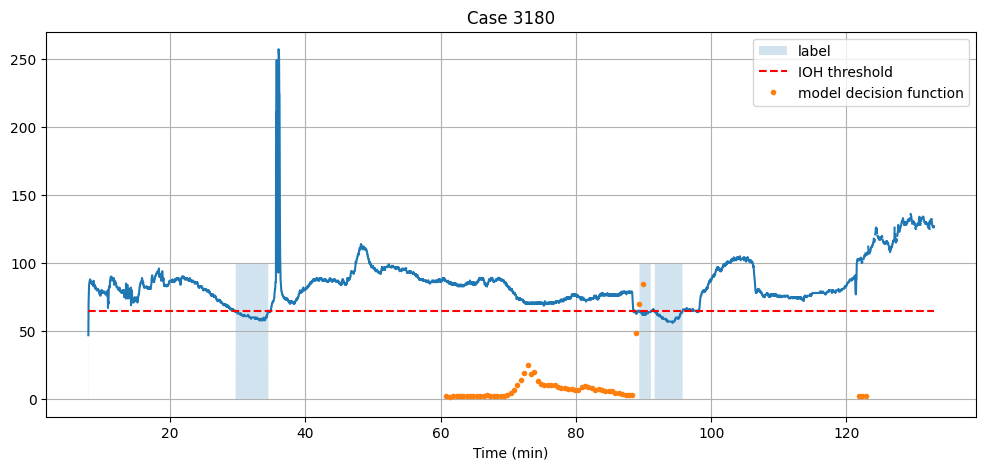

In [29]:
# plot 3 random cases with the corresponding decision function
from scripts.dataLoader import label_caseid

np.random.seed(10)
cases = np.random.choice(test['caseid'].unique(), 3, replace=False)

for case in cases:
    raw_case = pd.read_parquet(f'data/cases/case-{case:04d}.parquet')
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # removing the nan values at the beginning and the ending
    case_valid_mask = ~raw_case.mbp.isna()
    raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    raw_case.Time = pd.to_timedelta(raw_case.Time, unit="s")
    raw_case.set_index('Time', inplace=True)
    raw_case = raw_case.resample('2s').ffill()
    raw_case= label_caseid(raw_case, 2)

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=FEATURE_NAME)
    x_test = segment_data[FEATURE_NAME]
    y_pred = model.predict(xgb.DMatrix(x_test))

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds/60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    plt.plot(raw_case.index.seconds/60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data['time'] / np.timedelta64(1, 's') /60,y_pred*100, '.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    # plt.xlim([35, 42])
    # plt.xlim([235, 245])
    # plt.ylim([42, 80])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()

